## Soiling Intervals Detection

This data set of current-voltage (I-V) curves and associated meteorological data for photovoltaic (PV) modules representing a flat-plate PV for one-year period. These publicly available data are intended to facilitate the validation of existing models for predicting the performance of PV modules and for the development of new and improved models. The data include a wide range of irradiance and temperature conditions representing each season.

The data include the following periods:

• Eugene – December 20, 2012, through January 20, 2014

• Cocoa – January 21, 2011, through March 4, 2012

• Golden – August 14, 2012, through September 24, 2013

In this notebook we are going to study the aforementioned dataset in order to identify periods of underperfoming due to soiling.

#### Loading Libraries

In [1]:
%matplotlib inline
import os,sys
import warnings
module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)
# from genmod.solarpaper import parse_csv
# from genmod.popu import *
# from genmod.procedure_fitness import *
# from genmod.listes import *
# from genmod.plot_eval import *
from genlib import *


#### Loading dataset

We denote the variables we extract from our datasets.

**poa**: The amount of solar irradiance in watts per square meter received on the PV module surface at the time indicated.

**mod_temp**: PV module back-surface temperature in degrees Celsius at the time indicated, measured behind center of cell near center of PV module.

**power**: Maximum power of PV module in watts at the time indicated.

**humidity**: Relative humidity at the site in percent, nearest 5-second average to the time indicated.

**precipitation**: Accumulated daily total precipitation in millimeters at the time indicated.

**soiling_derate**: Normalized metric comparing daily performance of a PV module to an identical PV module that is cleaned during daily maintenance.

In [2]:
import pandas as pd
filename ='golden.csv'

df=pd.read_csv(filename)
df['timestamp']=pd.to_datetime(df['timestamp'])
df=df.set_index('timestamp')
if filename=='golden.csv':
  df=df.loc[:'2013-06-24']


print('We reshape our dataset to 24h per point. As we observe soiling procedure is a slow in time event')
# print(f'The Features of are set are {df.columns}')
print(f'Shape of our Timeseries: {df.shape}')
df


We reshape our dataset to 24h per point. As we observe soiling procedure is a slow in time event
Shape of our Timeseries: (207, 7)


,poa,mod_temp,power,humidity,precipitation,div,soiling_derate
timestamp,,,,,,,
2012-08-14,0.702845,0.900660,0.612522,0.138939,0.0,0.248621,0.994
2012-08-15,0.460646,0.814200,0.408669,0.094540,0.0,0.335704,0.995
2012-08-16,0.509351,0.695448,0.459634,0.505782,0.0,0.358148,0.995
2012-08-17,0.728656,0.832355,0.650592,0.394974,0.0,0.332674,0.993
2012-08-18,0.798300,0.859112,0.712263,0.222876,0.0,0.305808,0.993
...,...,...,...,...,...,...,...
2013-06-20,0.702163,0.853479,0.615004,0.096175,0.0,0.211933,0.987
2013-06-21,0.440595,0.786854,0.379020,0.091091,0.0,0.198195,0.986
2013-06-22,0.466936,0.744031,0.410957,0.278472,0.0,0.220976,0.990


In [3]:
# df2 = pd.DataFrame(index = pd.date_range('2014-01-21','2014-02-4', freq='D'))
# # df=pd.concat([df,df[:15].reset_index(drop=True).set_index(df2.index)])
# df=pd.concat([df,df2])
# df.soiling_derate=df.soiling_derate.fillna(1)
# df=df.interpolate(method='linear')
df_old=df

In the next cell we are taking advantage of the soiling_derate variable which we can distinguish soiling periods in our sets to create a groundtruth. We filter those periods with **soiling_dates(y=0.991)** function. As **y** goes to 1 the output becomes more sensitive so more periods will be return.

We found 13 Soiling Events with decay less than 0.992 
The indication of the start of a Soil is presented with Bold line
The indication of the end of a Soil is presented with Uncontinious line


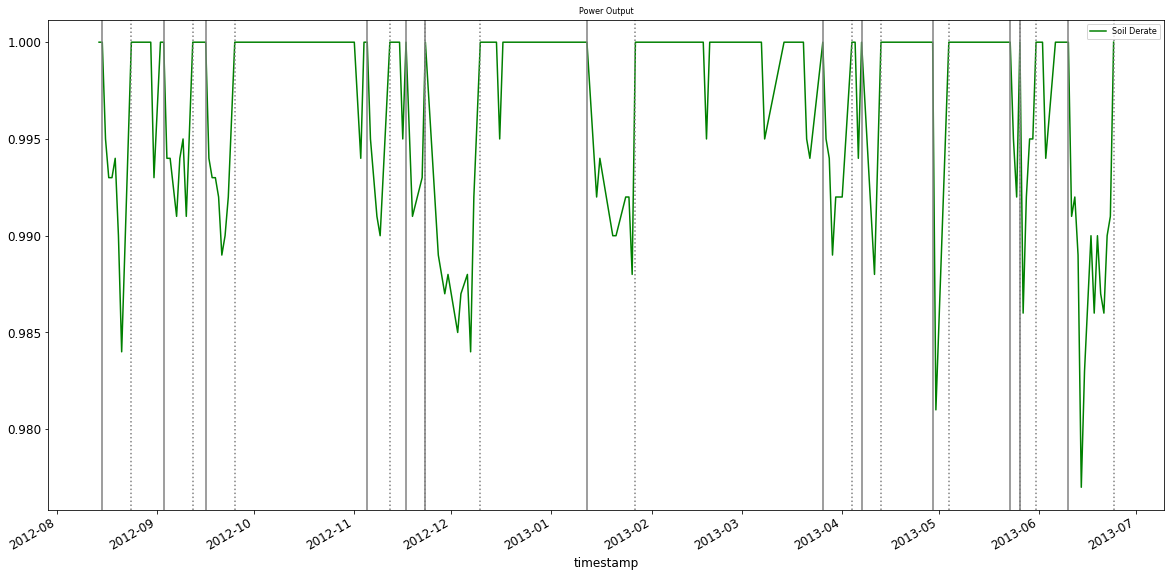

In [4]:
x=0.992
df.soiling_derate[-1]=1
if filename=='golden.csv':
    df.soiling_derate[0]=1
    df.soiling_derate[1]=1
df.soiling_derate[-1]=1
df_soil_output=soiling_dates(df,y=x,plot=True)
# print(f'Here we observe the exact dates which a soiling interval starts and stops')
# print(df_soil_output)

#### Motifs and Genetic algorithm

We rest on the matrixprofile algortihm and more specifically in the motif calculation algorithm by creating a domain of the several parameters it holds. On top of that we use a genetic algorithm in order to optimize the aforementioned
parameters which result into fiding soiling patterns(motifs).
To evaluate our approach, we use as training/testing data any of the Eugene, Cocoa, Golden panels.

### Parameters Initialization

In the next cell we initialize our parameters for a complete genetic run.

**col**: Columns which the matrix profile will be executed

**pop_size**: Population size. In our setting we create individuals (as many as the pop_size) which consist of 6 chromosomes. Namely those chromosomes are:

*min_neighbors*: The minimum number of similar matches a subsequence needs to have in order to be considered a motif.

*max_distance*: For a candidate motif,max_distance is the maximum distance allowed between the motif and the subsequence in order to be considered as a match.

*cutoff*: The largest matrix profile value (distance) that a candidate motif is allowed to have.

*max_matches*: The maximum amount of similar matches of a motif representative to be returned.

*max_motifs*: The maximum number of motifs to return.

*matrix_profile_windows*: Window size to perform the matrix profile.

**num_parents_mating**: Selects the parents using a user defined selection technique. Later, these parents will mate to produce the offspring. The techniques offered are: Selection Mating Pool, Steady State, Rank, Random, Tournament, Roulette Wheel Selection. (num_parents_mating must be always stricter less than pop_size)

**crossover**: Applies the  crossover. It randomly selects a gene at which crossover takes place between the pairs of parents through various techniques. The techniques offered are: Single_point, Two_points, Uniform, Scatter crossover.

**num_mutations**: Mutation changes a number of genes as defined by the num_mutations argument.The changes are random. More techniques to be **updated**.

**num_generations**: Number of genereations(loops) of the algorithm.

**mix_up**: True/False If true in each loop the pareting and crossover techniques are changing randomly.



In [5]:
col=['power']
pop_size = 300
num_parents_mating = 200
num_generations = 300
num_mutations=6
days=0
mix_up=True
#parenting=[smp,sss,ranks,randoms,tournament,rws,sus]
parenting='tournament'
#crossover=[single,twopoint,uni,scatter,old]
crossover='twopoint'
events=len(df_soil_output)

The goal of the procedure is to optimize the starting population through some steps.
1. Initialazing of the starting population.
2. Calculate a fitness function. We create a binary set of soiling & motif periods. In this setting we optimize the recall function from sklearn. We denote with class "1" the soiling and the motif periods, with class "0" when we have no soiling, motif period.

3. For the best output of fitness population we create the parents
4. From parents through crossover function we create the offspring (kids)
5. In order to avoid many identical solutions we mutate the offspring
6. Last step is to pass the offspring in the population for the next generation


#### Train Step

In [6]:
new_population,best_outputs,end_df,alles_df=procedure(df,df_soil_output,pop_size,days,
                                                      num_generations,num_parents_mating,
                                                      num_mutations,col,events,parenting,
                                                      crossover,mix_up)

100%|██████████| 300/300 [1:49:11<00:00, 21.84s/it]

Time to complete: 6551.37 seconds


:The individual which max the F1 function is: 6
Best solution fitness :  0.6601941747572816


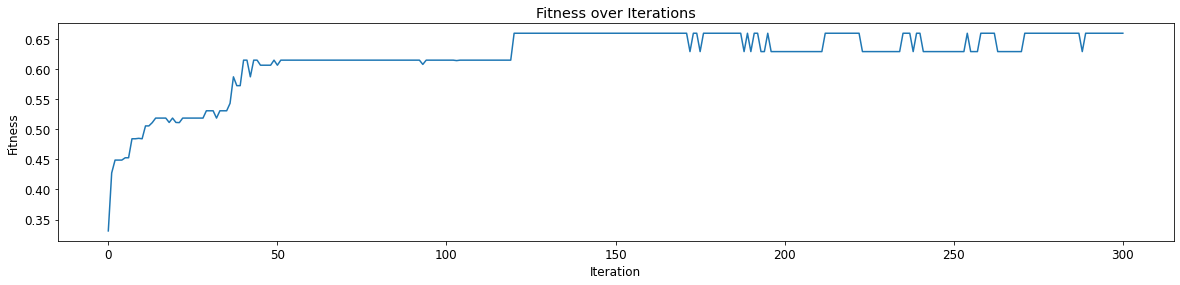

Shape of Result Frame
(1880, 16)


In [7]:
# print(best_outputs)
fitness,alles_df1 = fitness_fun(df,df_soil_output,days,new_population,col)
best_outputs.extend([np.max(fitness)])
# Then return the index of that solution corresponding to the best fitness.
best_match_idx = np.where(fitness == np.max(fitness))
print(f':The individual which max the F1 function is: {len(best_match_idx[0])}')
print("Best solution fitness : ", np.max(best_outputs))
import matplotlib.pyplot
matplotlib.pyplot.plot(best_outputs)
matplotlib.pyplot.title('Fitness over Iterations')
matplotlib.pyplot.xlabel("Iteration")
matplotlib.pyplot.ylabel("Fitness")
matplotlib.pyplot.show()
end_df=pd.concat([end_df,alles_df1])
end_df=end_df.reset_index(drop=True)
end_df=end_df.loc[end_df[['f1']].drop_duplicates(['f1']).index]
end_df=end_df.sort_values(by='f1',ascending=False)
end_df=end_df.reset_index(drop=True)
end_df.head(5)
print('Shape of Result Frame')
print(end_df.shape)

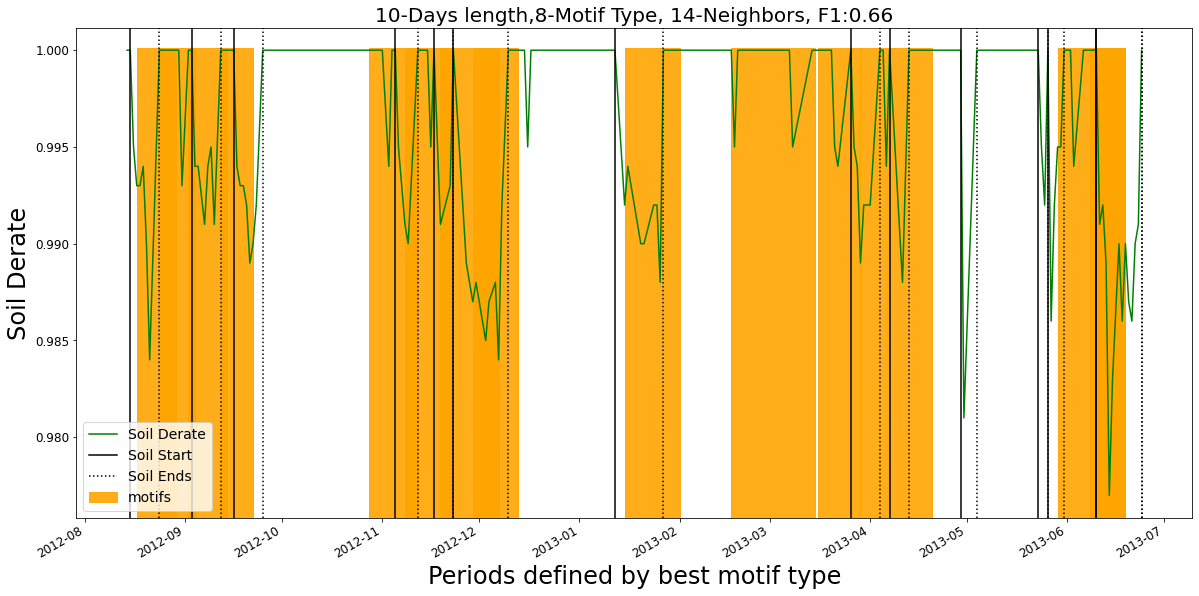

              precision    recall  f1-score   support

         0.0       0.77      0.58      0.66       118
         1.0       0.58      0.76      0.66        89

    accuracy                           0.66       207
   macro avg       0.67      0.67      0.66       207
weighted avg       0.69      0.66      0.66       207



In [8]:
try:
    motif_graph_multi_dim(col=col,df=df,
                  df_soil_output=df_soil_output,
                  alles_df=end_df,n=1,plot=True)
except:
    motif_graph_multi_dim(col=col,df=df,
                  df_soil_output=df_soil_output,
                  alles_df=end_df,n=1,plot=False)

### Motif based pattern discovery 
Here we test the results of the the previous panel to the other two.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~`
1/2
eugene.csv
We reshape our dataset to 24h per point. As we observe soiling procedure is a slow in time event
Shape of our Timeseries: (355, 7)
We found 11 Soiling Events with decay less than 0.992 


100%|██████████| 359/359 [03:55<00:00,  1.53it/s]

   profile_wind  exclusion_zone  motif_index  motif_type  actual_nei  \
0             8             2.0          186           9           9   
1             7             3.0           19           2          11   
2            10             9.0           26           3          10   
3             6             2.0          187           6          11   
4             8             4.0          186          10          10   
5             9             9.0           17           2          11   

   actual_motif   recall       f1  precision  hamming  jaccard    cohen  
0             9  0.52273  0.58599    0.66667  0.18310  0.58599  0.47065  
1             8  0.53409  0.58385    0.64384  0.18873  0.58385  0.46318  
2             5  0.60227  0.57609    0.55208  0.21972  0.57609  0.42818  
3             8  0.50000  0.57516    0.67692  0.18310  0.57516  0.46181  
4            10  0.52273  0.57500    0.63889  0.19155  0.57500  0.45296  
5             8  0.56818  0.57471    0.58140  0.208

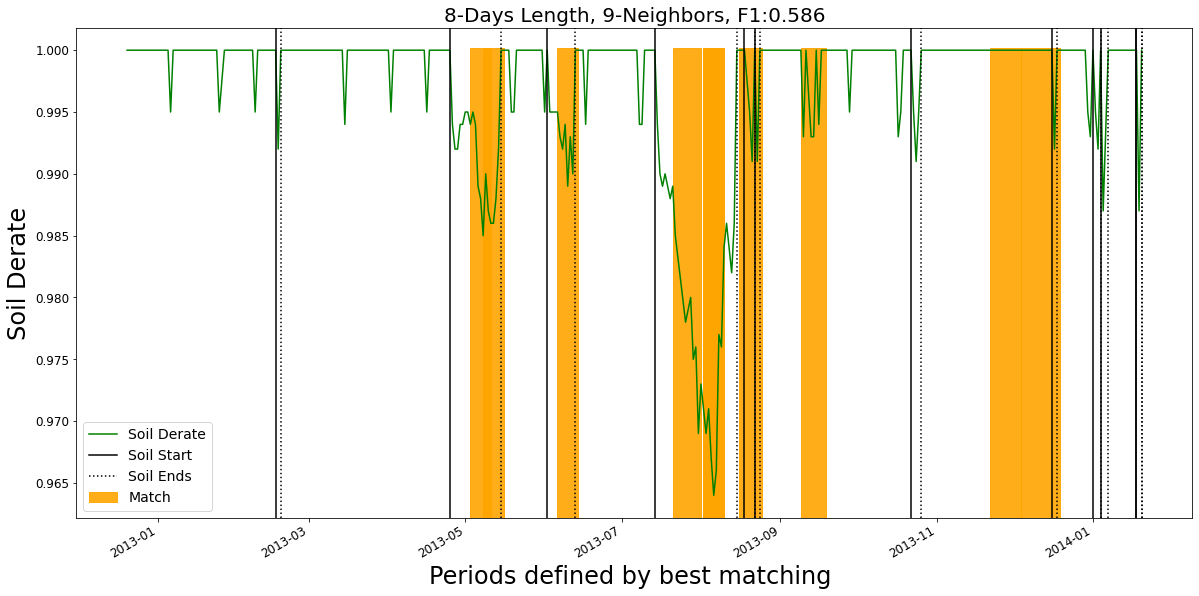

              precision    recall  f1-score   support

         0.0       0.85      0.91      0.88       267
         1.0       0.67      0.52      0.59        88

    accuracy                           0.82       355
   macro avg       0.76      0.72      0.73       355
weighted avg       0.81      0.82      0.81       355

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~`
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~`
2/2
cocoa.csv
We reshape our dataset to 24h per point. As we observe soiling procedure is a slow in time event
Shape of our Timeseries: (331, 7)
We found 7 Soiling Events with decay less than 0.992 


100%|██████████| 359/359 [03:34<00:00,  1.67it/s]

   profile_wind  exclusion_zone  motif_index  motif_type  actual_nei  \
0            12             inf           43           2           7   
1            10             4.0           45           3           7   
2            12             3.0           41           2           7   
3            12             1.0           41           3           7   
4            11             7.0           44           1           7   
5            12             9.0           44           1           7   

   actual_motif   recall       f1  precision  hamming  jaccard    cohen  
0             9  0.74419  0.55172    0.43836  0.15710  0.55172  0.46410  
1             7  0.69767  0.54545    0.44776  0.15106  0.54545  0.46000  
2             8  0.74419  0.50794    0.38554  0.18731  0.50794  0.40633  
3             8  0.74419  0.50394    0.38095  0.19033  0.50394  0.40100  
4             6  0.65116  0.50000    0.40580  0.16918  0.50000  0.40471  
5             4  0.67442  0.49573    0.39189  0.178

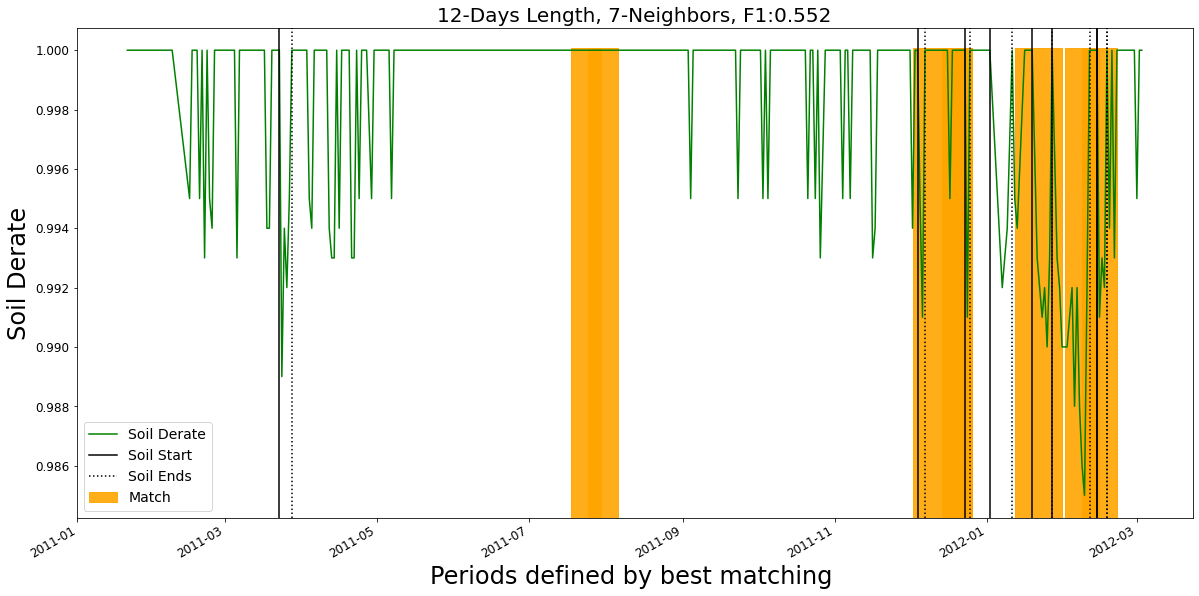

              precision    recall  f1-score   support

         0.0       0.96      0.86      0.90       288
         1.0       0.44      0.74      0.55        43

    accuracy                           0.84       331
   macro avg       0.70      0.80      0.73       331
weighted avg       0.89      0.84      0.86       331

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~`


In [9]:
files=['eugene.csv',
       'cocoa.csv']
count=1
for i,file in enumerate(files):
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~`")
    print(f'{count}/{len(files)}')
    print(file)
    count=count+1
    filename = file
    df=pd.read_csv(filename)
    df['timestamp']=pd.to_datetime(df['timestamp'])
    df=df.set_index('timestamp')
    #testing step
    if file=='golden.csv':
      # df=df.loc[:'2013-06-24']

      df.soiling_derate[0]=1
      df.soiling_derate[1]=1

    df.soiling_derate[-1]=1
    ##testing step
    print('We reshape our dataset to 24h per point. As we observe soiling procedure is a slow in time event')
    print(f'Shape of our Timeseries: {df.shape}')
    df_soil_output=soiling_dates(df,y=x,plot=False)
#     print(f'Here we observe the exact dates which a soiling interval starts and stops')
#     print(df_soil_output)
    events=len(df_soil_output)
    df_new=df
    out,df_last=matching_eval(col,df_old,df_new,alles_df=end_df[end_df.f1>0.5],
                              events=len(df_soil_output),df_soil_output=df_soil_output,
                              n=len(end_df[end_df.f1>0.5]),plot=False)
    # df_last.to_csv(f'/home/pgidarakos/Genetic/Eugene/indirect_eval_{i}_deliv.csv',columns=df_last.columns,index=False)
    print(df_last.head(6))
    match_graph_multi_dim_eval(col,df_new,df_old,df_soil_output=df_soil_output,alles_df=df_last,n=1,plot=True)

    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~`")

### MP based pattern discovery 

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
eugene.csv
1/2
We reshape our dataset to 24h per point. As we observe soiling procedure is a slow in time event
Shape of our Timeseries: (370, 7)
We found 11 Soiling Events with decay less than 0.992 
   min_nei  max_d  cutoff  max_m  max_motif  profile_wind  exclusion_zone  \
0        0   3.44    6.07     17          9            12             2.0   
1        0   4.77    6.28     15          9            12             inf   
2        0   4.86    6.32     16          9            12             inf   
3        0   2.32    1.42     16          8             8             7.0   
4        0   3.41    4.06     16          9            11             inf   

         f1   jaccard    recall   hamming      pres  motif_type  
0  0.707317  0.707317  0.682353  0.129730  0.734177           3  
1  0.694611  0.694611  0.682353  0.137838  0.707317           6  
2  0.651685  0.651685  0.

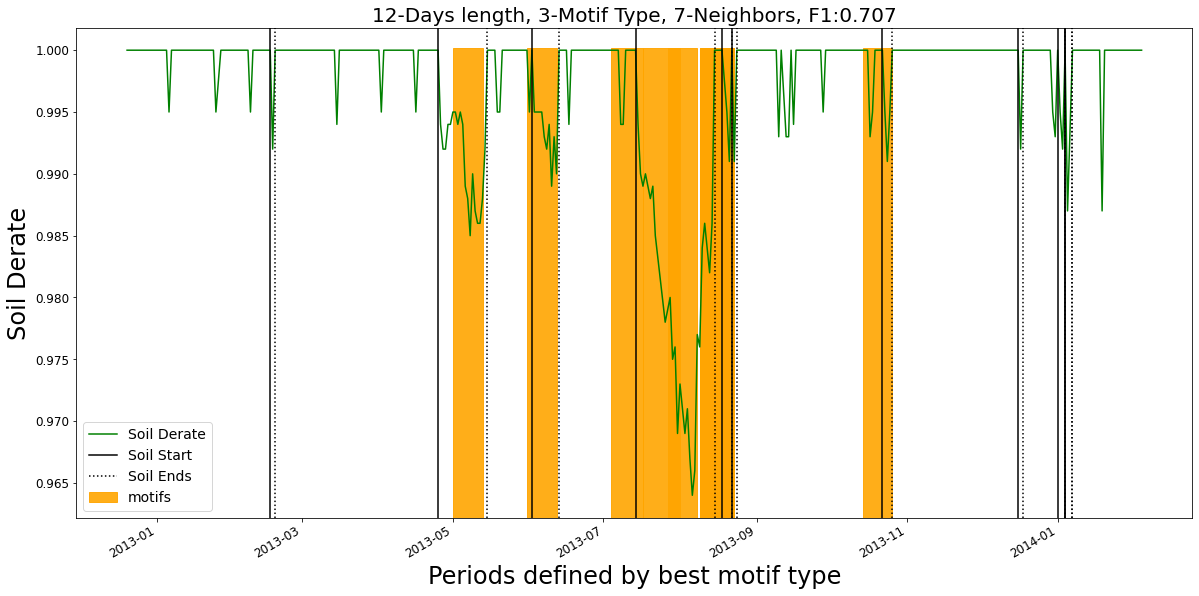

              precision    recall  f1-score   support

         0.0       0.91      0.93      0.92       285
         1.0       0.73      0.68      0.71        85

    accuracy                           0.87       370
   macro avg       0.82      0.80      0.81       370
weighted avg       0.87      0.87      0.87       370

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
cocoa.csv
2/2
We reshape our dataset to 24h per point. As we observe soiling procedure is a slow in time event
Shape of our Timeseries: (331, 7)
We found 7 Soiling Events with decay less than 0.992 
   min_nei  max_d  cutoff  max_m  max_motif  profile_wind  exclusion_zone  \
0       -1   2.74    3.63     17          7            11             5.0   
1        0   2.31    3.29     17          7            10             6.0   
2        0  

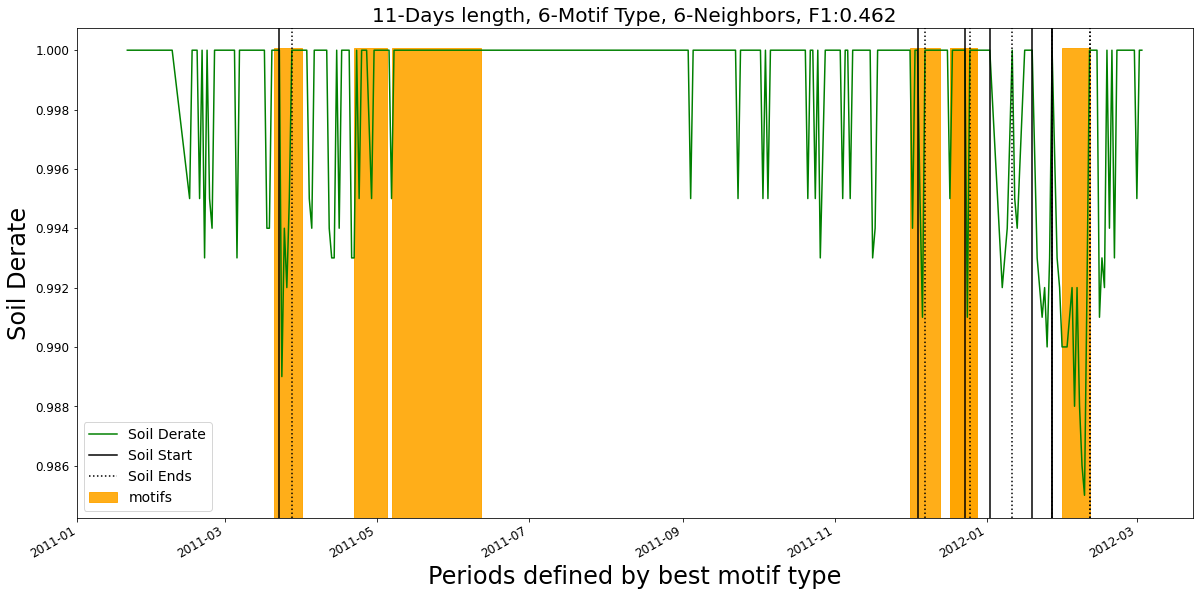

              precision    recall  f1-score   support

         0.0       0.95      0.86      0.90       293
         1.0       0.36      0.63      0.46        38

    accuracy                           0.83       331
   macro avg       0.66      0.74      0.68       331
weighted avg       0.88      0.83      0.85       331

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [10]:
files=['eugene.csv',
       'cocoa.csv']
count=1
for i,file in enumerate(files):
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
    print(file)
    print(f'{count}/{len(files)}')
    count=count+1
    filename = file
    df=pd.read_csv(filename)
    df['timestamp']=pd.to_datetime(df['timestamp'])
    df=df.set_index('timestamp')
    #testing step
    if file == 'eugene.csv':
      df2 = pd.DataFrame(index = pd.date_range('2014-01-21','2014-02-4', freq='D'))
# df=pd.concat([df,df[:15].reset_index(drop=True).set_index(df2.index)])
      df=pd.concat([df,df2])
      df.soiling_derate=df.soiling_derate.fillna(1)
      df=df.interpolate(method='linear')
    if file=='golden.csv':
        df=df.loc[:'2013-06-24']

        df.soiling_derate[0]=1
        df.soiling_derate[1]=1

    df.soiling_derate[-1]=1
    ##testing step
    print('We reshape our dataset to 24h per point. As we observe soiling procedure is a slow in time event')
    print(f'Shape of our Timeseries: {df.shape}')
    df_soil_output=soiling_dates(df,y=x,plot=False)
    df_soil_output=df_soil_output[:-1]
#     print(f'Here we observe the exact dates which a soiling interval starts and stops')
#     print(df_soil_output)
    events=len(df_soil_output)
    eval_df,_,_=evaluate_motifs(col,df,df_soil_output,alles_df=end_df[['min_nei', 'max_d', 'cutoff', 'max_m', 'max_motif', 'profile_wind','exclusion_zone']])
    eval_df=pd.concat([end_df[['min_nei', 'max_d', 'cutoff', 'max_m', 'max_motif', 'profile_wind','exclusion_zone']],eval_df],axis=1)
    eval_df=eval_df.loc[eval_df[['f1']].drop_duplicates(['f1']).index]
    eval_df=eval_df.sort_values(by='f1',ascending=False)
    eval_df=eval_df.reset_index(drop=True)
    print(eval_df.head())
    # eval_df.to_csv(f'/home/pgidarakos/Genetic/Eugene/direct_eval_{i}_deliv.csv',columns=eval_df.columns,index=False)

    motif_graph_multi_dim_eval(col=col,df=df,
                      df_soil_output=df_soil_output,
                      alles_df=eval_df,n=1,plot=True)
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")